In [1]:
from datetime import datetime, timedelta
import pickle
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from tldextract import extract
import langid

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 50)

from newspaper import Article
import matplotlib.pyplot as plt

<ipython-input-1-cd00b3c2a068>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NOTE: Mediacloud news for state-specific collection includes news ABOUT the particular state, and as such, might sometimes contain news from national outlets where the article itself might be focused on the state itself. Most (if not all) of the collection is going to be sourced from local state-specific outlets, but not always. Currently, we are keeping all URLs within the obtained collection for the state, except those from nytimes and foxnews since those are our chosen national outlets. Trusting mediacloud's collections to be truly state-focused even when urls come from national outlets. 

In [2]:
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

In [3]:
ny_news = pd.read_csv('data/mediacloud_newyork.csv')
print(ny_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   archived_url  7173 non-null   object
 1   article_url   7173 non-null   object
 2   id            7173 non-null   int64 
 3   language      7173 non-null   object
 4   media_name    7173 non-null   object
 5   media_url     7173 non-null   object
 6   publish_date  7173 non-null   object
 7   title         7173 non-null   object
 8   url           7173 non-null   object
dtypes: int64(1), object(8)
memory usage: 504.5+ KB
None


In [4]:
#analyze the distribution across months of publication -- are there gaps in the collection?
all_dates = list(ny_news['publish_date'])
month_to_vol = {}
for i in range(1, 13):
    month_to_vol[i] = 0
for d in tqdm(all_dates):
    m = int(d.split('-')[1])
    month_to_vol[m] += 1

100%|██████████| 7173/7173 [00:00<00:00, 836295.83it/s]


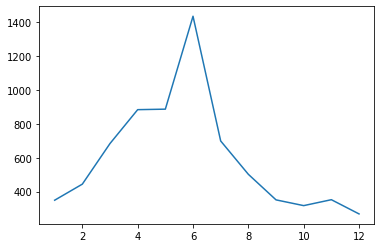

In [5]:
plt.plot(list(month_to_vol.keys()), list(month_to_vol.values()))

In [6]:
ny_news[['language', 'media_name', 'media_url', 'publish_date', 'title', 'url']].tail(20)

,language,media_name,media_url,publish_date,title,url
7153,en,iol.co.za,http://iol.co.za,2023-10-26 00:00:00,"The rise of Yaya Mavundla, one of SA's most influential trans woman",https://www.iol.co.za/sunday-tribune/lifestyle/the-rise-of-yaya-mavundla-one-of-sas-most-influential-trans-women-a53d96ab-e9aa-4b49-9843-b1ab55ec9699
7154,en,iol.co.za,http://iol.co.za,2023-10-09 00:00:00,Transgender women make history as they participate in Miss Universe,https://www.iol.co.za/sunday-tribune/lifestyle/transgender-women-make-history-as-they-participate-in-miss-universe-839ce124-6a15-4f6b-94aa-cde7180d21ed
7155,en,iol.co.za,http://iol.co.za,2023-06-11 00:00:00,Woolworths customers divided over support for gay pride,https://www.iol.co.za/sunday-tribune/news/woolworths-customers-divided-over-support-for-gay-pride-eb22ca93-bbbc-4a8c-9999-d3e2279c1315
7156,en,iol.co.za,http://iol.co.za,2023-10-13 00:00:00,5 travel tips for first-time LGBTQIA+ travellers,https://www.iol.co.za/sunday-tribune/travel/5-travel-tips-for-first-time-lgbtqia-travellers-7fd9f8bd-ec85-4d67-a323-a7cab12102d8
7157,en,iol.co.za,http://iol.co.za,2023-12-01 00:00:00,8 ways corporates can protect women business travellers in sub-Saharan Africa,https://www.iol.co.za/sunday-tribune/travel/8-ways-corporates-can-protect-women-business-travellers-in-sub-saharan-africa-31be6d0b-caa2-435b-92bc-f186ff2ebf3a
7158,en,iol.co.za,http://iol.co.za,2023-07-24 00:00:00,Bye Bye Birdie: Twitter will lose bird logo in brand overhaul,https://www.iol.co.za/technology/bye-bye-birdie-twitter-will-lose-bird-logo-in-brand-overhaul-says-elon-musk-49dc2e4d-ffde-5272-8a9b-d40ea1589d3a
7159,en,iol.co.za,http://iol.co.za,2023-01-22 00:00:00,Meta is reviewing the call to make adult nudity policies more inclusive,https://www.iol.co.za/technology/software-and-internet/meta-is-reviewing-the-call-to-make-adult-nudity-policies-more-inclusive-66d774b1-2313-46c2-8c52-5936b13595d0
7160,en,iol.co.za,http://iol.co.za,2023-03-06 00:00:00,Anglican Church Synod of Bishops agree on pastoral care for LGBTQI members,https://www.iol.co.za/the-star/news/anglican-church-synod-of-bishops-agree-on-pastoral-care-for-lgbtqi-members-6fab8a5c-278f-4bc8-a3eb-bf5b013defee
7161,en,iol.co.za,http://iol.co.za,2023-08-18 00:00:00,Charlize Theron sparks social media conversations about how she dresses her children,https://www.iol.co.za/the-star/news/charlize-theron-sparks-social-media-conversations-about-how-she-dresses-her-children-8d57aeeb-68ff-45e9-adf5-a6f7b7162af5
7162,en,iol.co.za,http://iol.co.za,2023-11-01 00:00:00,"GDE must educate teachers and learners on sexual orientation, says DA",https://www.iol.co.za/the-star/news/gde-must-educate-teachers-and-learners-on-sexual-orientation-says-da-0ff3210f-ab35-403a-8631-ac1992d32b7f


In [7]:
relevant_news = ny_news[~ny_news['media_name'].isin(['foxnews.com',
                                                     'nytimes.com'])]
relevant_news = relevant_news[relevant_news['language']=='en']
relevant_news = relevant_news[['media_name', 'publish_date', 'title', 'url']]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5990 entries, 0 to 7172
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   media_name    5990 non-null   object
 1   publish_date  5990 non-null   object
 2   title         5990 non-null   object
 3   url           5990 non-null   object
dtypes: object(4)
memory usage: 234.0+ KB
None


In [8]:
relevant_news.publish_date = pd.to_datetime(relevant_news.publish_date)
relevant_news = relevant_news[relevant_news['publish_date'].dt.date >= start_date]
relevant_news = relevant_news[relevant_news['publish_date'].dt.date <= end_date]
print(relevant_news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5990 entries, 0 to 7172
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    5990 non-null   object        
 1   publish_date  5990 non-null   datetime64[ns]
 2   title         5990 non-null   object        
 3   url           5990 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 234.0+ KB
None


In [9]:
def get_article_from_url(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        subtitle = article.meta_description
        if subtitle == '' or subtitle == ' ':
            subtitle = None
        text = article.text
        if text == '' or text == ' ':
            text = None
    except:
        subtitle = None
        text = None
    return subtitle, text

In [10]:
subtitles, texts = [], []
all_urls = list(relevant_news['url'])
for url in tqdm(all_urls):
    subtitle, text = get_article_from_url(url)
    subtitles.append(subtitle)
    texts.append(text)
relevant_news['subtitle'] = subtitles
relevant_news['text'] = texts
print(relevant_news.info())

100%|██████████| 5990/5990 [1:51:24<00:00,  1.12s/it]  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5990 entries, 0 to 7172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   media_name    5990 non-null   object        
 1   publish_date  5990 non-null   datetime64[ns]
 2   title         5990 non-null   object        
 3   url           5990 non-null   object        
 4   subtitle      3118 non-null   object        
 5   text          4726 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 327.6+ KB
None


In [11]:
relevant_news.to_csv('data/newyork_article_texts_and_info.csv',
                     index=False)